# Parallelism Demo

Consider a function, $f$,

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$


In [1]:
import hellaPy
from plt_style import *
import numpy as np
import pylab as plt
import scipy as sp
%matplotlib inline

In [2]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                52
On-line CPU(s) list:   0-51
Thread(s) per core:    1
Core(s) per socket:    26
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 85
Model name:            Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz
Stepping:              7
CPU MHz:               1000.012
CPU max MHz:           4000.0000
CPU min MHz:           1000.0000
BogoMIPS:              4200.00
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              1024K
L3 cache:              36608K
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflus

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           187G        7.0G        167G        492M         13G        179G
Swap:           31G         46M         31G


In [28]:
N = 2**20+1
t = np.linspace(0,10*np.pi,N)[:-1]
f = np.array([ (-1)**k*np.sin(ell*t)/ell**2 for k,ell in enumerate(2*np.arange(31)+1) ]).sum(axis=0)

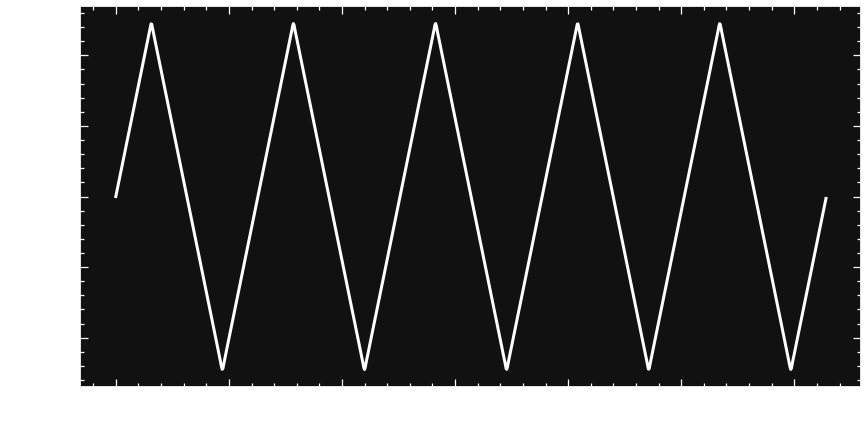

In [29]:
skip  = 1000
ts,fs= [ u[::skip] for u in [t,f] ]
plt.figure(figsize=(14,7))
plt.plot(ts,fs,'w-',lw=3)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')

In [30]:
%%time
#hellaPy.mkl_set_num_threads(1)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 975 ms, sys: 22.2 ms, total: 997 ms
Wall time: 33.1 ms


In [31]:
%%time
hellaPy.mkl_set_num_threads(2)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 2
CPU times: user 1.17 s, sys: 32.3 ms, total: 1.2 s
Wall time: 38.7 ms


In [32]:
%%time
hellaPy.mkl_set_num_threads(4)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 4
CPU times: user 135 ms, sys: 4.94 ms, total: 140 ms
Wall time: 34.7 ms


In [33]:
%%time
hellaPy.mkl_set_num_threads(8)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 8
CPU times: user 261 ms, sys: 5.84 ms, total: 267 ms
Wall time: 33.2 ms


In [34]:
%%time
hellaPy.mkl_set_num_threads(16)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 16
CPU times: user 637 ms, sys: 13.1 ms, total: 650 ms
Wall time: 43.4 ms


In [35]:
%%time
hellaPy.mkl_set_num_threads(32)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 32
CPU times: user 1.48 s, sys: 29.6 ms, total: 1.51 s
Wall time: 49.5 ms


In [11]:
!uptime

 11:09:28 up 32 days,  1:23,  0 users,  load average: 0.87, 0.39, 0.23


In [12]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.arange(len(q))
p   = q/q.max()
k   = np.linspace(1,11,1001)

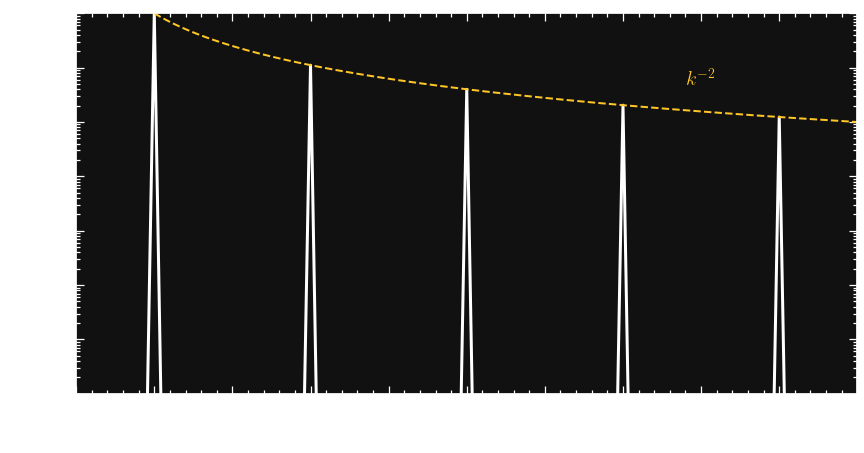

In [13]:
plt.figure(figsize=(14,7))
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.arange(10),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum On the CPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the cartesian product of two orthogonal triangle waves.

In [ ]:
import cheb

In [ ]:
N = 256
Do,xo = cheb.cheb(N)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")

In [ ]:
X,Y,Z = np.meshgrid(x,x,x,indexing='ij')
U = np.array([ np.cos(ell*X)*np.sin(ell*Z)/ell**3 for ell in 2*np.arange(31)+1 ]).sum(axis=0)

In [ ]:
hellaPy.mkl_set_num_threads(40)

In [ ]:
%%time
dUdx = np.einsum('ij,jkl->ikl',D,U)

In [ ]:
dUdx_iter = 0*dUdx

In [ ]:
%%time
for k in range(U.shape[-1]):
    dUdx_iter[:,:,k] = D @ U[:,:,k]

In [ ]:
f,a = hellaPy.no_ax_fax()
L   = np.abs(dUdx).max() * np.linspace(-1,1,16)
hellaPy.mycontourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=hellaPy.mycm15)